In [2]:
using Pkg
import Pkg
using JuMP
using CairoMakie
using CSV
using DataFrames
using DataFramesMeta
using Chain
using StatsBase
import StatsBase: countmap
import Printf: @printf
using Printf
using PkgVersion
using Ipopt
using Optim
using ShiftedArrays
import ShiftedArrays: lag
using LinearAlgebra
using Observables

Explore the Data

In [3]:
cd("/Users/mariostsoukis/Documents/NYU/IO_II/HW_3")  

df= CSV.read("/Users/mariostsoukis/Documents/NYU/IO_II/HW_3/rust_data_2020_chris.csv", DataFrame)
select!(df, Not(1)) # remove silly column which just counts rows
sort!(df, [:bus_id, :period_id])

describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,period_id,74.5,0,74.5,149,0,Int64
2,y_it,0.0368,0,0.0,1,0,Int64
3,x_it,18.0519,0,17.0,56,0,Int64
4,bus_id,24.5,0,24.5,49,0,Int64


In [4]:
read_and_sort(path) = sort!(CSV.read(path, DataFrame), [:bus_id, :period_id])
load_data(path::String) = CSV.read(path, DataFrame)

load_data (generic function with 1 method)

Part 0

The below is done in such a way to be more efficient. 

In [5]:
# Transition & counts builder
function build_transition_and_counts(df::DataFrame, N::Int)
    sort!(df, [:bus_id, :period_id])

    # compute x_prev = lag(x_it) within each bus
    df2 = transform(groupby(df, :bus_id),
                    :x_it => lag => :x_prev)
    dropmissing!(df2, :x_prev)

    # flatten and mask to valid states
    x_prev = Int.(df2.x_prev)
    x      = Int.(df2.x_it)
    y      = df2.y_it
    mask   = (0 .<= x_prev .< N) .& (0 .<= x .< N)
    x_prev, x, y = x_prev[mask], x[mask], y[mask]

    # counts by previous state and action
    keep_map    = countmap(x_prev[y .== 0])
    rep_map     = countmap(x_prev[y .== 1])
    counts_keep = [get(keep_map, j, 0) for j in 0:N-1]
    counts_rep  = [get(rep_map,  j, 0) for j in 0:N-1]

    # build & normalize transition matrix for "keep"
    P = zeros(Float64, N, N)
    for ((j,k), c) in countmap(zip(x_prev[y .== 0], x[y .== 0]))
        P[j+1, k+1] = c
    end
    row_sums = sum(P, dims=2)
    nz = vec(row_sums .> 0)
    P[nz, :] .= P[nz, :] ./ row_sums[nz]
    for j in findall(!, nz)
        P[j, j] = 1.0
    end

    return P, counts_keep, counts_rep
end

function compute_pmf(df::DataFrame, y_val::Int)
    # add Δx column inline
    df2 = @chain df begin
        groupby(:bus_id)
        @transform(_, :delta_x = vcat(missing, Base.diff(:x_it)))
    end

    # filter
    df3 = filter(r -> r.y_it == y_val && !ismissing(r.delta_x), df2)

    # PMF
    cnts = countmap(df3.delta_x)
    xs   = sort(collect(keys(cnts)))
    tot  = sum(values(cnts))

    DataFrame(
      delta_x = xs,
      count   = [cnts[x] for x in xs],
      prob    = [cnts[x] / tot for x in xs]
    )
end

# build
P, counts_keep, counts_rep = build_transition_and_counts(df, 201)

#
println("Transition Matrix Populated")

# verify
row_sums = vec(sum(P, dims=2))
tol = 1e-8
if all(abs.(row_sums .- 1.0) .< tol)
    println("Tot bé, rows add to 1")
else
    println("Warning: Tenim Problemes")
end

# compute and store the pmf for y=0
pmf0 = compute_pmf(df, 0)

# now you can print it
using Printf

println(" Δx   count   Pr(Δx | y = 0)")
for r in eachrow(pmf0)
    @printf("%+4d   %5d   %8.4f\n", r.delta_x, r.count, r.prob)
end
@printf("\n Σ Pr(Δx | y = 0) = %.6f\n", sum(pmf0.prob))

println("Transition Matrix Populated")

Transition Matrix Populated
Tot bé, rows add to 1
 Δx   count   Pr(Δx | y = 0)
  +0     650     0.0906
  +1    3125     0.4356
  +2    3322     0.4631
  +3      77     0.0107

 Σ Pr(Δx | y = 0) = 1.000000
Transition Matrix Populated


Now I do Parts 2,3

In [6]:
# MPEC estimation
function estimate_mpec(P, counts_keep, counts_rep, δ)
    N = size(P,1)
    model = Model(Ipopt.Optimizer)
    set_silent(model)

    @variable(model, θ₁ ≥ 1e-6)
    @variable(model, θ₂ ≥ 1e-6)
    @variable(model, β  ≥ 1e-6)
    @variable(model, V[1:N])
    @variable(model, v_keep[1:N])
    @variable(model, v_rep)

    @NLexpression(model, x_grid[j=1:N], (j-1)/100)
    @NLexpression(model, EV_keep[j=1:N], sum(P[j,k] * V[k] for k in 1:N))

    @NLconstraint(model, [j=1:N],
        v_keep[j] + θ₁*x_grid[j] + θ₂*x_grid[j]^2 - δ * EV_keep[j] == 0
    )
    @NLconstraint(model, v_rep + β - δ * V[1] == 0)

    @NLexpression(model, denom[j=1:N], exp(v_keep[j]) + exp(v_rep))
    @NLexpression(model, σ_keep[j=1:N], exp(v_keep[j]) / denom[j])
    @NLconstraint(model, [j=1:N], V[j] == log(denom[j]))

    @NLobjective(model, Min, -sum(
        counts_keep[i] * log(σ_keep[i]) +
        counts_rep[i]  * log(1 - σ_keep[i])
      for i in 1:N))

    set_start_value.( (θ₁, θ₂, β), 1.0 )
    set_start_value.(V,      -5.0)
    set_start_value.(v_keep, -5.0)
    set_start_value(v_rep,  -15.0)

    set_optimizer_attribute(model, "tol",         1e-8)
    set_optimizer_attribute(model, "mu_strategy", "adaptive")
    optimize!(model)

    θ1_m = value(θ₁)
    θ2_m = value(θ₂)
    β_m   = value(β)
    ll    = -objective_value(model)

    return θ1_m, θ2_m, β_m, ll
end

# NFXP helpers
function solve_ev_nfxp(P, θ₁, θ₂, β, δ; tol=1e-8)
    N = size(P,1)
    x = collect(0:N-1) ./ 100
    V = zeros(N)
    diff = Inf
    while diff > tol
        EV     = P * V
        v_k    = -(θ₁*x .+ θ₂*x.^2) .+ δ * EV
        v_r    = -β + δ * V[1]
        V_new  = log.(exp.(v_k) .+ exp.(v_r))
        diff   = norm(V_new - V, Inf)
        V      = V_new
    end
    return V
end

function compute_ccp_nfxp(V, θ₁, θ₂, β, P, δ)
    N = length(V)
    x = collect(0:N-1) ./ 100
    EV = P * V
    v_k = -(θ₁*x .+ θ₂*x.^2) .+ δ * EV
    v_r = -β + δ * V[1]
    return exp.(v_k) ./ (exp.(v_k) .+ exp.(v_r))
end

function neg_loglik_nfxp(p, P, c_keep, c_rep, δ)
    θ₁, θ₂, β = p
    (θ₁ ≤ 0 || θ₂ ≤ 0 || β ≤ 0) && return Inf
    V = solve_ev_nfxp(P, θ₁, θ₂, β, δ)
    σ = compute_ccp_nfxp(V, θ₁, θ₂, β, P, δ)
    -sum(c_keep .* log.(σ) .+ c_rep .* log.(1 .- σ))
end

#  Main runner 
function main_part_rust(path; N::Int, δ::Float64)
    df = load_data(path)
    P, counts_keep, counts_rep = build_transition_and_counts(df, N)

    θ1_m, θ2_m, β_m, ll_mpec = estimate_mpec(P, counts_keep, counts_rep, δ)

    @printf("MPEC Results:\n θ₁ = %.6f, θ₂ = %.6f, β = %.6f, LL = %.6f\n", 
            θ1_m, θ2_m, β_m, ll_mpec)

    res = optimize(
      x -> neg_loglik_nfxp(x, P, counts_keep, counts_rep, δ),
      [θ1_m, θ2_m, β_m],
      NelderMead(),
      Optim.Options(show_trace = false)
    )
    ll_nfxp = -res.minimum
    θ1_hat, θ2_hat, β_hat = res.minimizer

    @printf("NFXP Results:\n θ₁ = %.6f, θ₂ = %.6f, β = %.6f, LL = %.6f\n",
            θ1_hat, θ2_hat, β_hat, ll_nfxp)

    return P, θ1_m, θ2_m, β_m, θ1_hat, θ2_hat, β_hat
end

# Execute
#main_part_rust("rust_data_2020_chris.csv"; N=201, δ=0.975); This does not store results
P, θ1_m, θ2_m, β_m, θ1_hat, θ2_hat, β_hat = main_part_rust("rust_data_2020_chris.csv"; N=201, δ=0.975);



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

MPEC Results:
 θ₁ = 2.617654, θ₂ = 0.336390, β = 12.846505, LL = -861.875603
NFXP Results:
 θ₁ = 2.617654, θ₂ = 0.336390, β = 12.846505, LL = -861.875603


And now I do some extra meta things

Firstly, I compare my results with Chris' Github answers. 

In [7]:
chris_θ = (2.4569, 0.03, 11.7257)
my_θ = (θ1_hat, θ2_hat, β_hat)
nll_chris = -neg_loglik_nfxp(chris_θ, P, counts_keep, counts_rep, 0.975);
my_ll = -861.875603;

@printf("My θ:       θ₁ = %.4f, θ₂ = %.4f, β = %.4f\n", my_θ...)
@printf("Chris θ:    θ₁ = %.4f, θ₂ = %.4f, β = %.4f\n", chris_θ...)

@printf("My -LL:     %.6f\n",       my_ll)
@printf("Chris -LL:  %.6f\n",         nll_chris)


My θ:       θ₁ = 2.6177, θ₂ = 0.3364, β = 12.8465
Chris θ:    θ₁ = 2.4569, θ₂ = 0.0300, β = 11.7257
My -LL:     -861.875603
Chris -LL:  -863.337313


It would appear that my results are better? Maybe speak to Chris?

Secondly, now plots!

In [8]:
function plot_ev_keep!(
    P::AbstractMatrix,
    θ1_m::Real, θ2_m::Real, β_m::Real,
    θ1_hat::Real, θ2_hat::Real, β_hat::Real,
    δ::Real;
    savepath::AbstractString = "EV_keep_MPEC_vs_NFXP.svg",
    backend::AbstractString  = "svg",
    dpi::Int                 = 800
)

    # solve for value‐functions
    V_mpec = solve_ev_nfxp(P, θ1_m,   θ2_m,   β_m,   δ) #yes I use function destined for NFXP, but actually nothing here is exclusive to NFXP.
    V_nfxp = solve_ev_nfxp(P, θ1_hat, θ2_hat, β_hat, δ)

    # expected E[V'|keep]
    EV_mpec = P * V_mpec
    EV_nfxp = P * V_nfxp

    # state‐index
    states = 0:(size(P,1)-1)

    fig = Figure(size = (800, 600), dpi = dpi)

    ax1 = Axis(fig[1, 1];
        xlabel = "State j",
        ylabel = "E[V′ | y = 0]",
        title  = "Expected Value of not Replacing Engine")
    lines!(ax1, states, EV_mpec; label = "MPEC",  linewidth = 2)
    lines!(ax1, states, EV_nfxp; label = "NFXP", linewidth = 2, linestyle = :dash)
    axislegend(ax1, position = :rb)

    ax2 = Axis(fig[2, 1];
        xlabel = "State j",
        ylabel = "MPEC − NFXP")
    lines!(ax2, states, EV_mpec .- EV_nfxp; linewidth = 2)
    hlines!(ax2, [0]; linestyle = :dot, color = :gray)

    # save to disk
    save(savepath, fig)
    println(" Figure saved to “$(savepath)”")

    return fig
end

plot_ev_keep! (generic function with 1 method)

MPEC Results:
 θ₁ = 2.617654, θ₂ = 0.336390, β = 12.846505, LL = -861.875603
NFXP Results:
 θ₁ = 2.617654, θ₂ = 0.336390, β = 12.846505, LL = -861.875603
 Figure saved to “EV_keep_vs_NFXP.png”


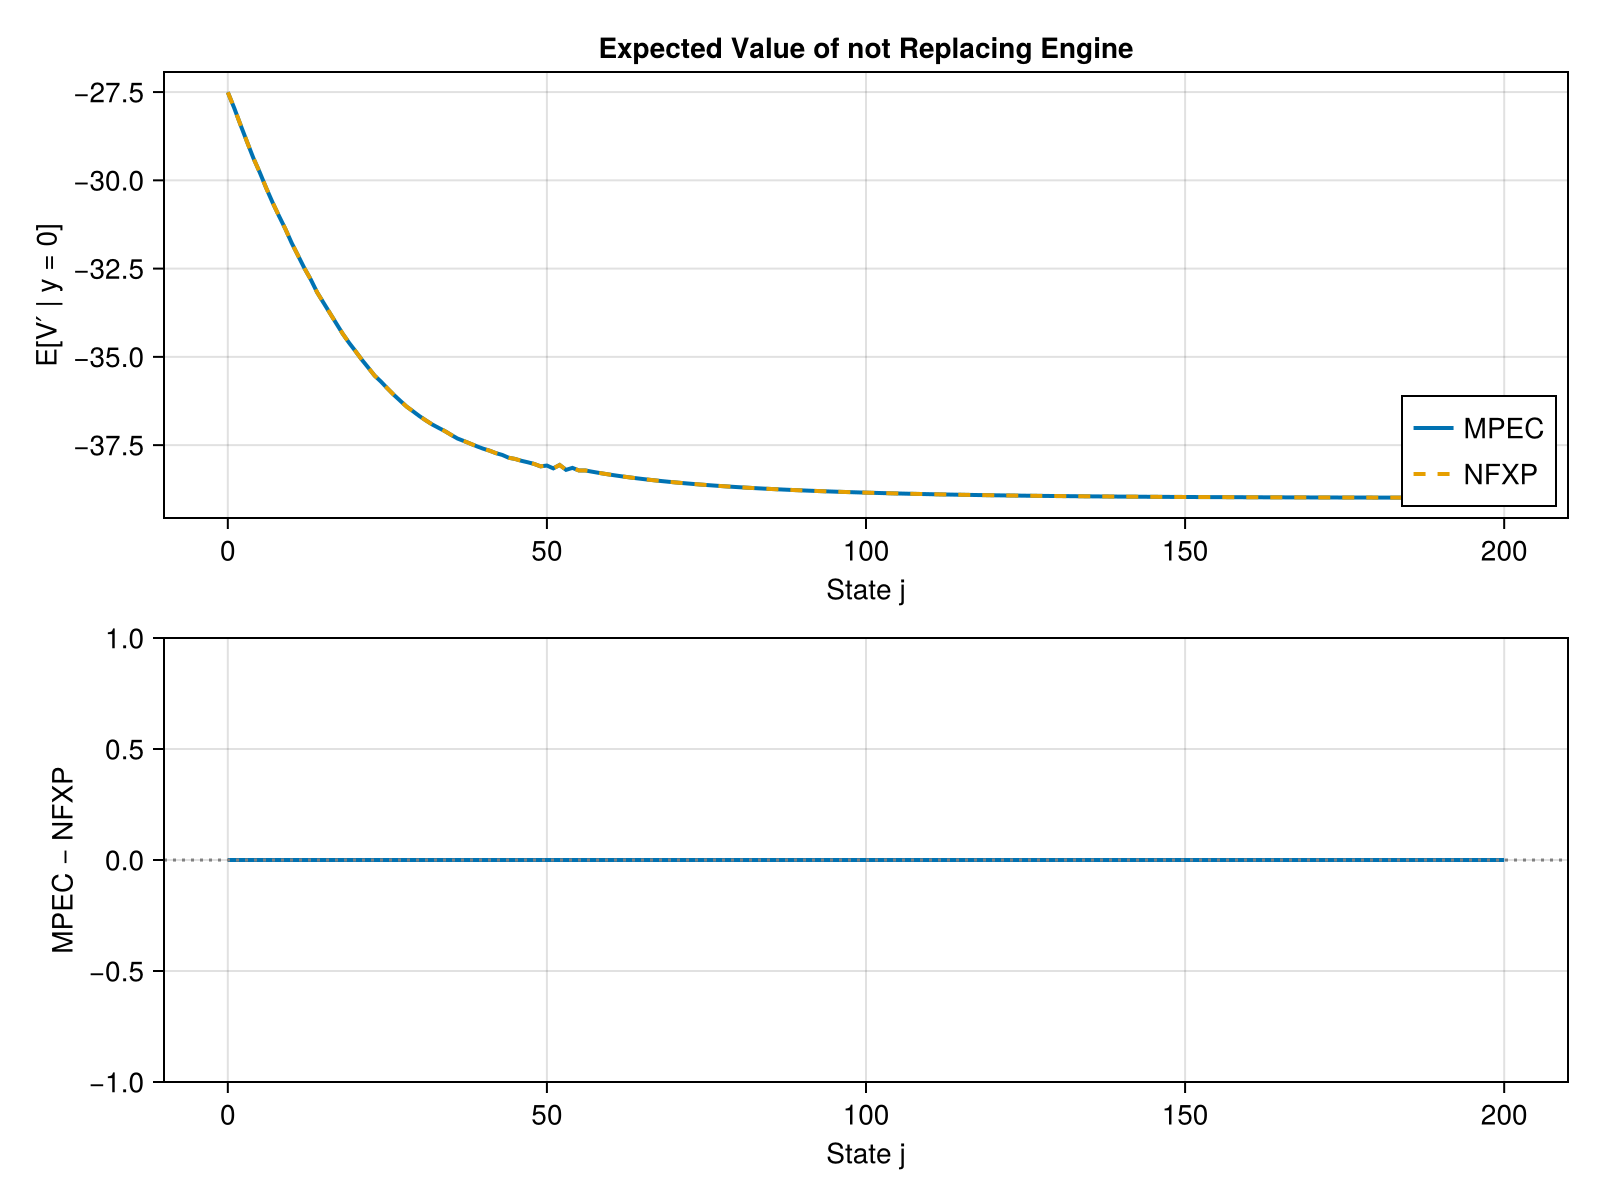

In [9]:
function run_and_plot(
    path::AbstractString;
    N::Int=201,
    δ::Float64=0.975,
    savepath::AbstractString="EV_keep_vs_NFXP.png",
    backend::AbstractString="png",
    dpi::Int=800
)
    # unpack P plus the MPEC & NFXP parameters
    P, θ1_m, θ2_m, β_m, θ1_hat, θ2_hat, β_hat =
        main_part_rust(path; N=N, δ=δ)

    # 
    fig = plot_ev_keep!(
        P,
        θ1_m, θ2_m, β_m,
        θ1_hat, θ2_hat, β_hat,
        δ;
        savepath = savepath,
        backend  = backend,
        dpi      = dpi,
    )

    display(fig)  
    return nothing
end

run_and_plot("rust_data_2020_chris.csv"; N=201, δ=0.975)

The negative expected values we observe are expected. I only include the disutility (cost) of running a bus service, not utility (which to simplify we can assume to be constant and exogenous). I could add an arbitrary constant to the plot; this would result in positive expected values, as it would simply shift up the curves. 

In [10]:
θ1_m, θ2_m, β_m, θ1_hat, θ2_hat, β_hat, ll_nfxp =
    main_part_rust("rust_data_2020_chris.csv"; N=201, δ=0.975);

df = load_data("rust_data_2020_chris.csv")
P, counts_keep, counts_rep = build_transition_and_counts(df, 201);

MPEC Results:
 θ₁ = 2.617654, θ₂ = 0.336390, β = 12.846505, LL = -861.875603
NFXP Results:
 θ₁ = 2.617654, θ₂ = 0.336390, β = 12.846505, LL = -861.875603


Figure saved to “replacement_demand.png”


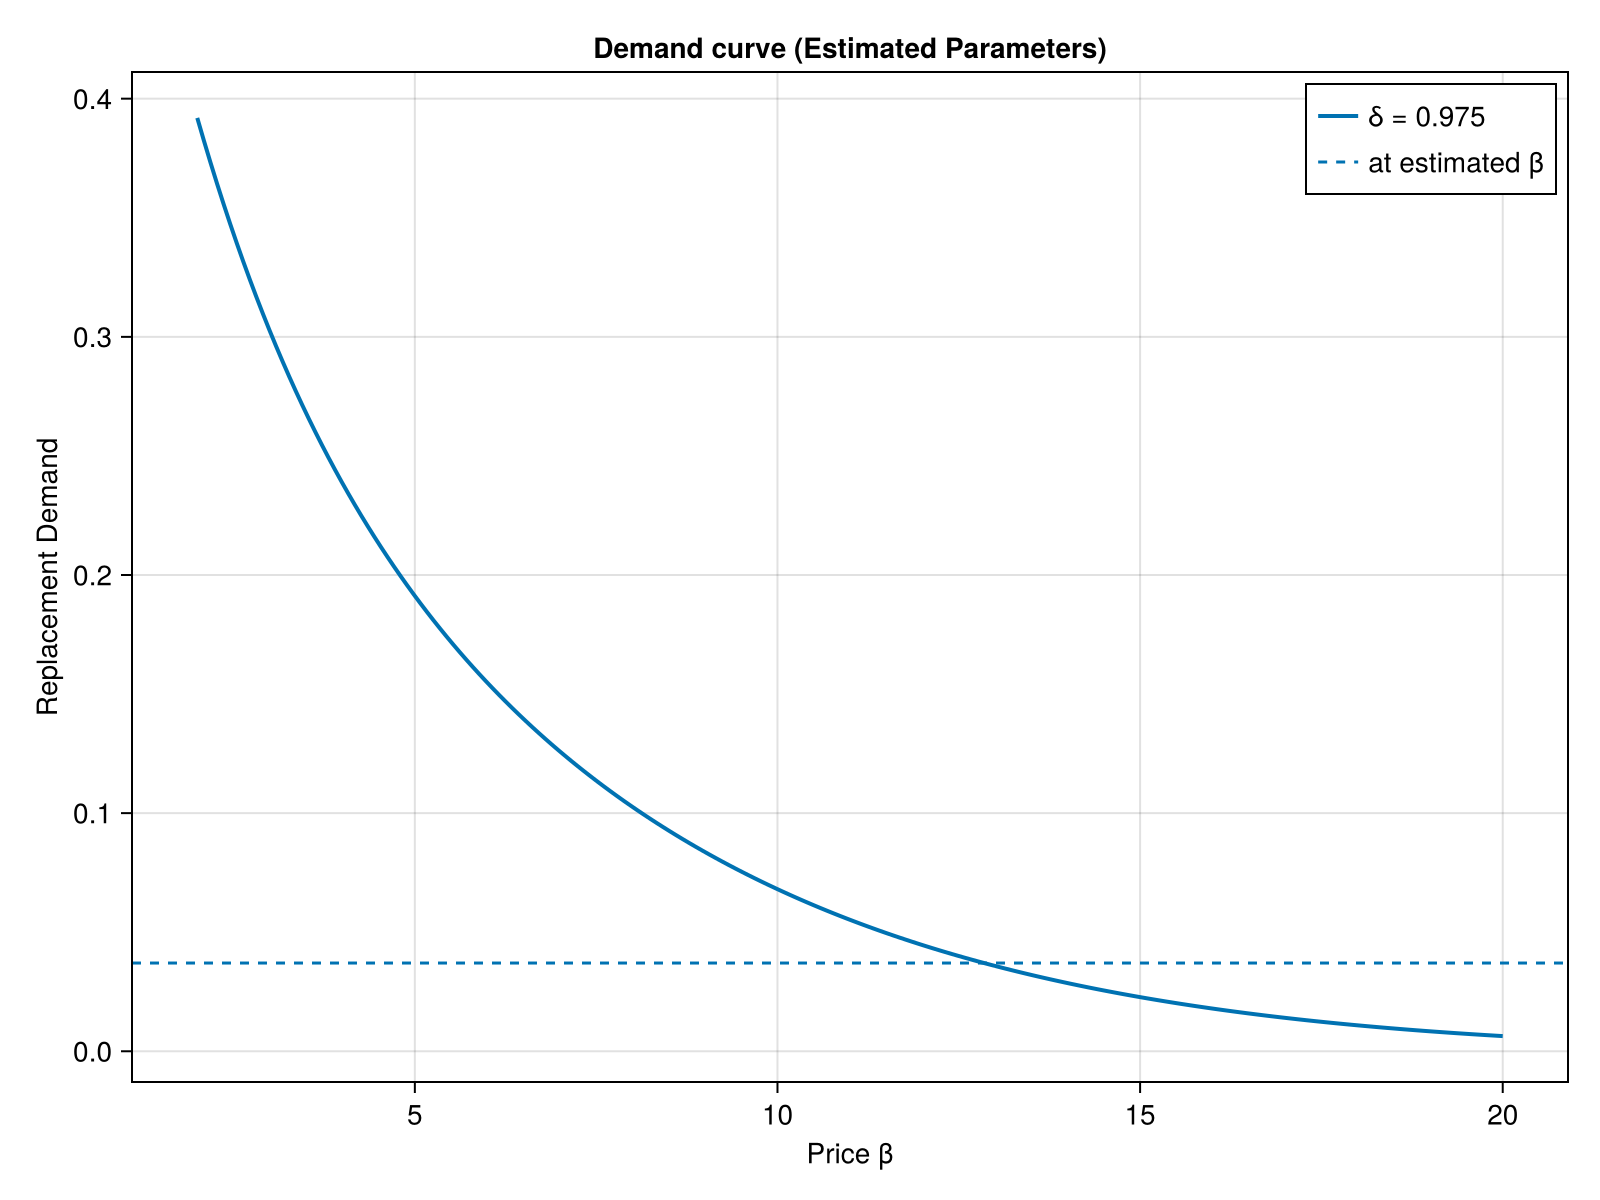

In [11]:
function plot_replacement_demand(
    path::AbstractString;
    N::Int = 201,
    δ::Float64 = 0.975,
    β_range = range(0.0, stop=25.0, length=200),
    savepath::AbstractString = "replacement_demand.png",
    backend::AbstractString  = "png",
    dpi::Int                 = 600
)
    # load data & build P + state‐counts
    df = load_data(path)
    P, counts_keep, counts_rep = build_transition_and_counts(df, N)

    #  estimate via MPEC
    θ1_m, θ2_m, β_m, _ = estimate_mpec(P, counts_keep, counts_rep, δ)

    #  empirical state‐distribution
    totals = counts_keep .+ counts_rep
    π_emp  = totals ./ sum(totals)

    # for each β, compute replacement demand
    demands = Float64[]
    for β in β_range
        V    = solve_ev_nfxp(P, θ1_m, θ2_m, β, δ)
        keep = compute_ccp_nfxp(V, θ1_m, θ2_m, β, P, δ)
        rep  = 1 .- keep
        push!(demands, dot(rep, π_emp))
    end

    # plot price vs. demand
    CairoMakie.activate!(; type=backend)
    fig = Figure(size=(800,600), dpi=dpi)
    ax  = Axis(fig[1,1];
               xlabel = "Price β",
               ylabel = "Replacement Demand",
               title  = "Demand curve (Estimated Parameters)")
               lines!(ax, β_range, demands;
               label = "δ = $(round(δ, sigdigits=3))",
               linewidth=2)
    hlines!(ax, [dot(1 .- compute_ccp_nfxp(
                          solve_ev_nfxp(P, θ1_m, θ2_m, β_m, δ),
                          θ1_m, θ2_m, β_m, P, δ),
                        π_emp)],
            linestyle=:dash, label="at estimated β")
    axislegend(ax)

    save(savepath, fig)
    println("Figure saved to “$(savepath)”")

    return fig
end

# call:
plot_replacement_demand("rust_data_2020_chris.csv";
N = 201,
β_range = range(2, stop=20, length=200),
dpi = 800)


Comparison across δ

Figure saved to “replacement_demand_comparison.png”


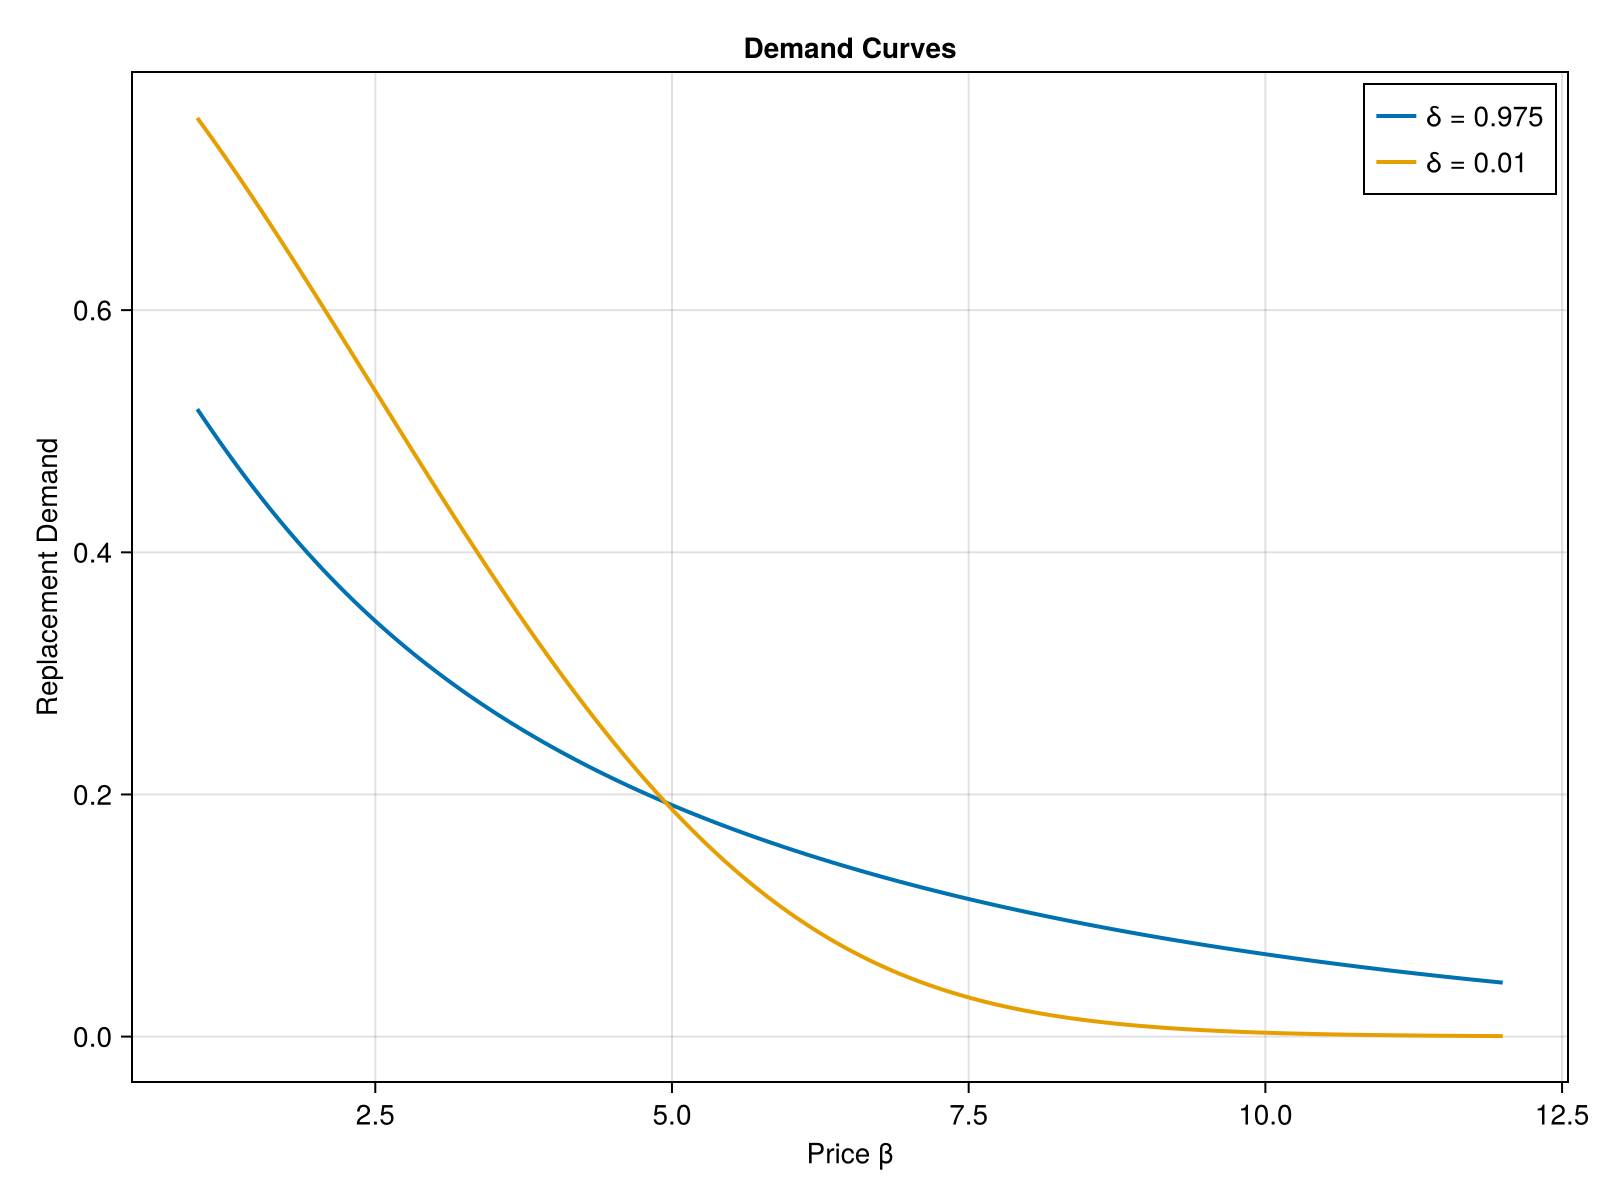

In [12]:
function plot_replacement_demand(
    path::AbstractString;
    N::Int = 201,
    δs::AbstractVector{Float64} = [0.975, 0.01],
    β_range = range(1.0, stop=12.0, length=200),
    savepath::AbstractString = "replacement_demand_multi.png",
    backend::AbstractString  = "png",
    dpi::Int                 = 300
)
    #  Load data & build P + state counts
    df = load_data(path)
    P, counts_keep, counts_rep = build_transition_and_counts(df, N)
    π_emp = (counts_keep .+ counts_rep) ./ sum(counts_keep .+ counts_rep)

    #  estimate via MPEC
    demand_profiles = Dict{Float64, Vector{Float64}}()
    for δ in δs
        θ1_m, θ2_m, β_m, _ = estimate_mpec(P, counts_keep, counts_rep, δ)

    # for each β, compute replacement demand
    demands = Float64[]
        for β in β_range
            V    = solve_ev_nfxp(P, θ1_m, θ2_m, β, δ)
            σ    = compute_ccp_nfxp(V, θ1_m, θ2_m, β, P, δ)
            rep  = 1 .- σ
            push!(demands, dot(rep, π_emp))
        end

        demand_profiles[δ] = demands
    end

    # plot price vs. demand
    CairoMakie.activate!(; type = backend)
    fig = Figure(size = (800, 600), dpi = dpi)
    ax  = Axis(fig[1,1];
               xlabel = "Price β",
               ylabel = "Replacement Demand",
               title  = "Demand Curves")

    for δ in δs
        lines!(ax, β_range, demand_profiles[δ];
               label = "δ = $(δ)", linewidth = 2)
    end
    axislegend(ax, position = :rt)

    save(savepath, fig)
    println("Figure saved to “$(savepath)”")

    return fig
end

plot_replacement_demand("rust_data_2020_chris.csv";
                       N = 201,
                       δs = [0.975, 0.01],
                       β_range = range(1, stop=12, length=200),
                       savepath = "replacement_demand_comparison.png",
                       backend = "png",
                       dpi = 800)


Cool Gif

In [13]:
using GLMakie  
function animate_replacement_demand_lift(
    path::AbstractString;
    N::Int = 201,
    δ_values = range(0.01, stop=0.99, length=60),
    β_range  = range(2.0, stop=20.0, length=200),
    savepath = "replacement_demand_lift.gif",
    fps::Int = 12
)
    # Precompute P & estates
    df = load_data(path)
    P, counts_keep, counts_rep = build_transition_and_counts(df, N)
    π_emp = (counts_keep .+ counts_rep) ./ sum(counts_keep .+ counts_rep)

    #  Observable for δ
    δ_obs = Observable(first(δ_values))

    #  Lifted Observable for the demand curve
    demand_obs = @lift begin
        δ = $δ_obs
        θ1, θ2, βm, _ = estimate_mpec(P, counts_keep, counts_rep, δ)
        # NOTE: β_range is not an Observable, so use it directly
        [ dot(1 .- compute_ccp_nfxp(
                  solve_ev_nfxp(P, θ1, θ2, β, δ),
                  θ1, θ2, β, P, δ),
             π_emp)
          for β in β_range ]
    end

    # Lifted Observable for the horizontal marker
    marker_obs = @lift begin
        δ = $δ_obs
        θ1, θ2, βm, _ = estimate_mpec(P, counts_keep, counts_rep, δ)
        dot(1 .- compute_ccp_nfxp(
                 solve_ev_nfxp(P, θ1, θ2, βm, δ),
                 θ1, θ2, βm, P, δ),
            π_emp)
    end

    # Set up the figure 
    fig = Figure(size = (800, 600))
    ax  = Axis(fig[1, 1]; xlabel="Price β", ylabel="Replacement Demand",
               title = "δ = ?")

    lines!(ax, β_range, demand_obs; color=:blue, label="Demand")
    hlines!(ax, marker_obs;    linestyle=:dash, label="at observed β")
    axislegend(ax, position=:rt)

    # Record animation; update δ_obs[]
    record(fig, savepath, δ_values; framerate=fps) do δ
        δ_obs[] = δ
        ax.title = "Demand curve as δ evolves- (δ = $(round(δ, sigdigits=3)))"
    end

    println("Saved animation to $savepath")
    return nothing
end

animate_replacement_demand_lift("rust_data_2020_chris.csv";
    N        = 201,
    δ_values = range(0.01, stop=0.99, length=60),
    β_range  = range(2, stop=20, length=200),
    savepath = "replacement_demand_lift.gif",
    fps      = 16,
)

Saved animation to replacement_demand_lift.gif
